#### Цель проекта: 
проанализировать трафик сайта и подготовить рекомендации для отдела маркетинга для групп посетителей (группы разбить по источникам привлечения и типу устройств)

### **Импорт библиотек и файлов**


In [1]:
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_palette('YlGnBu')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
visits = pd.read_csv('visits_log.csv')
costs = pd.read_csv('costs.csv')
orders = pd.read_csv('orders_log.csv')

# **Первый взгляд на данные**

**Дано**

---

1.   Логи каждого посетителя с типом девайса, длительностью сессии и источником привлечения. 
2.   Покупки  каждого пользователя с датой покупки и выручкой по заказу. 
3. Затраты по дням и каналам привлечения. 

**Найти**

---
Продукт
* Сколько людей пользуются в день, неделю, месяц?
* Сколько сессий в день?
* Сколько длится одна сессия?
* Как часто люди возвращаются?

Продажи
* Когда люди начинают покупать?
* Сколько раз покупают за период?
* Какой средний чек?
* Сколько денег приносят? (LTV)

Маркетинг
* Сколько денег потратили? Всего / на каждый источник / по времени
* Сколько стоило привлечение одного покупателя из каждого источника?
* На сколько окупились расходы? (ROI)


### **Логи**

In [3]:
visits.sample(10, replace = True)

,Device,End Ts,Source Id,Start Ts,Uid
358657,desktop,2017-09-19 12:11:19,5,2017-09-19 12:11:00,2451770740785329493
245180,desktop,2017-10-09 21:47:00,3,2017-10-09 21:43:00,360244377590101668
45022,desktop,2017-11-07 11:26:00,1,2017-11-07 11:13:00,18284148332048508621
237370,desktop,2018-01-10 18:42:00,4,2018-01-10 18:15:00,10265455748681672003
324592,desktop,2018-03-05 14:06:00,3,2018-03-05 14:06:00,9192691161770963677
215518,desktop,2017-12-05 09:48:00,4,2017-12-05 09:21:00,13592477024265563300
278743,desktop,2018-01-29 13:20:00,3,2018-01-29 13:09:00,9673830015056210583
41791,desktop,2017-12-02 13:01:00,3,2017-12-02 12:58:00,4112459635354299213
119463,touch,2018-05-25 21:00:00,4,2018-05-25 20:55:00,15194504292521009940
319566,desktop,2017-10-30 18:56:00,5,2017-10-30 18:37:00,5837174767227818604


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Недобные названия столбцов и неправильный формат дат - исправим. 

In [5]:
visits.rename(columns = {'Uid':'uid', 
                         'Device':'device','End Ts': 'end_ts', 
                         'Source Id':'source_id', 
                         'Start Ts': 'start_ts'}, inplace = True)

visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

visits = visits[(visits['start_ts'] > '2017-06-01 00:00:00') 
                & (visits['start_ts'] < '2018-05-31 23:59:59')] #фильтр на нужный период 


In [6]:
visits_data = visits.copy() #сохраним копию первоначальных данных 

### **Затраты на привлечение**

In [7]:
costs.sample(10, replace = True)

,source_id,dt,costs
304,1,2018-04-03,42.96
1014,3,2018-03-16,252.37
1954,9,2017-10-17,22.27
174,1,2017-11-22,72.41
1234,4,2017-10-24,243.86
1579,5,2017-10-06,224.15
1693,5,2018-01-28,129.77
1854,9,2017-07-09,5.18
661,2,2018-03-26,212.38
1533,5,2017-08-21,88.50


In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Поменяем снова тип данных в столбце с датой. 

In [9]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs_data = costs.copy()

In [10]:
costs.rename(columns = {'dt':'acquisition_date'}, inplace = True)

### **Заказы**

In [11]:
orders.sample(10, replace = True)

,Buy Ts,Revenue,Uid
3887,2017-07-18 18:41:00,3.05,16924936355857656665
32625,2018-02-02 16:11:00,9.17,3073745967949090802
46877,2018-05-10 16:59:00,1.53,5065347938584855354
23994,2017-12-14 12:10:00,0.83,229074572579734709
4108,2017-07-21 10:43:00,3.05,6153813756352433261
12653,2017-10-13 22:55:00,2.81,483791262820800487
48740,2018-05-24 10:22:00,5.50,15633288156805502493
41304,2018-03-23 10:43:00,1.71,7654636749667288880
29735,2018-01-17 10:27:00,4.28,5900402411123134493
46515,2018-05-06 18:17:00,3.67,2067638931848625933


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [13]:
orders.rename(columns = {'Buy Ts':'buy_ts', 
                         'Revenue':'revenue',
                         'Uid':'uid'}, 
              inplace = True)

orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')
orders_data = orders.copy()
orders['order_year'] = orders['buy_ts'].dt.year

# **Анализ продукта**

## *Сколько людей пользуются в день, неделю, месяц?*



Используемые метрики: 

* DAU — количество уникальных пользователей в день;
* WAU - количество уникальных пользователей в неделю;
* MAU — количество уникальных пользователей в месяц.

In [14]:
# Добавим необходимые столбцы с днем, неделей, месяцем и годом посещения
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month']  = visits['start_ts'].astype('datetime64[M]')
visits['session_week']  = visits['start_ts'].astype('datetime64[W]')
visits['session_day']  = visits['start_ts'].dt.date
visits['session_day'] = pd.to_datetime(visits['session_day'])

Чтобы найти MAU, нужно сгруппировать данные по годам и месяцам и посчитать в каждом месяце количество уникальных пользователей. По это таблице уже можем выяснить среднее ежемесячное количество уникальных посетителей. 
По этой же логике найдем DAU и WAU.  

In [15]:
mau = int(visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean())
print('Количество уникальных пользователей в месяц в среднем состаляет: {} человек.'.format(mau))

Количество уникальных пользователей в месяц в среднем состаляет: 23228 человек.


In [16]:
wau = int(visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean())
print('Количество уникальных пользователей в неделю в среднем состаляет: {} человек.'.format(wau))

Количество уникальных пользователей в неделю в среднем состаляет: 5621 человек.


In [17]:
dau = int(visits.groupby('session_day').agg({'uid': 'nunique'}).mean())
print('Количество уникальных пользователей в день в среднем состаляет: {} человек.'.format(dau))


Количество уникальных пользователей в день в среднем состаляет: 907 человек.


### Посмотрим на эти же данные, но с разделением по платформам: 

In [18]:
for i in list(visits['device'].unique()):
    mau = int(visits[visits['device']==i].groupby(['session_year',
                                                   'session_month']).agg({'uid': 'nunique'}).mean())

    wau = int(visits[visits['device']==i].groupby(['session_year',
                                                   'session_week']).agg({'uid': 'nunique'}).mean())

    dau = int(visits[visits['device']==i].groupby(['session_year',
                                                   'session_day']).agg({'uid': 'nunique'}).mean())

    print('Количество уникальных пользователей в месяц/неделю/день на платформе {} в среднем состаляет: {}, {}, {} человек.'.format(i, mau, wau,dau))

Количество уникальных пользователей в месяц/неделю/день на платформе touch в среднем состаляет: 6825, 1607, 252 человек.
Количество уникальных пользователей в месяц/неделю/день на платформе desktop в среднем состаляет: 16724, 4061, 659 человек.


Видно, что большая часть пользователей заходят с комьютера. Логично, сайт Афиши довльно большой, мобильная версия уступает по информативности полной. Посмотрим на динамику показателей. 

### Динамика MAU по платформам

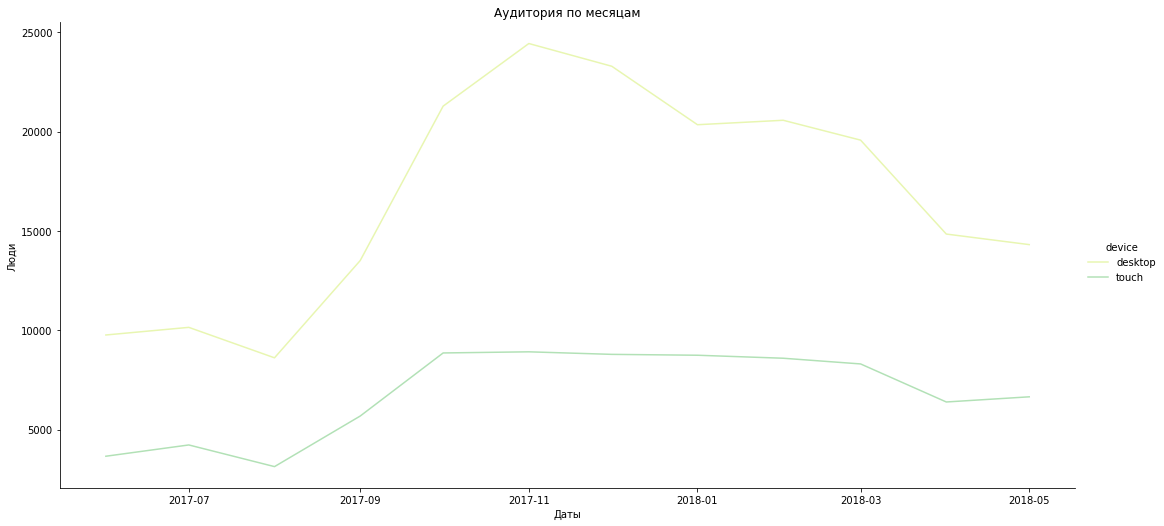

In [19]:
mau_device = visits.groupby(['device', 
                             'session_year',
                             'session_month']).agg({'uid': 'nunique'}).reset_index()

sns.relplot(x="session_month" , y="uid", hue="device", 
            kind="line", 
            height=7, 
            aspect=15/7, 
            data=mau_device)
plt.title("Аудитория по месяцам")
plt.ylabel('Люди')
plt.xlabel('Даты');

Видно, что с начала 17-го года росла аудитория на обеих платформах, но на ПК - активнее. Но в конце 17-го года произошел  спад и далее - стагнация. Возможно это связано с появлением конкуренции, например, Тинькофф Банк запустил в своем приложении похожий функционал и стал продавать билеты на мероприятия.  А может просто бюджет порезали, будем смотреть. 

### Динамика WAU по платформам


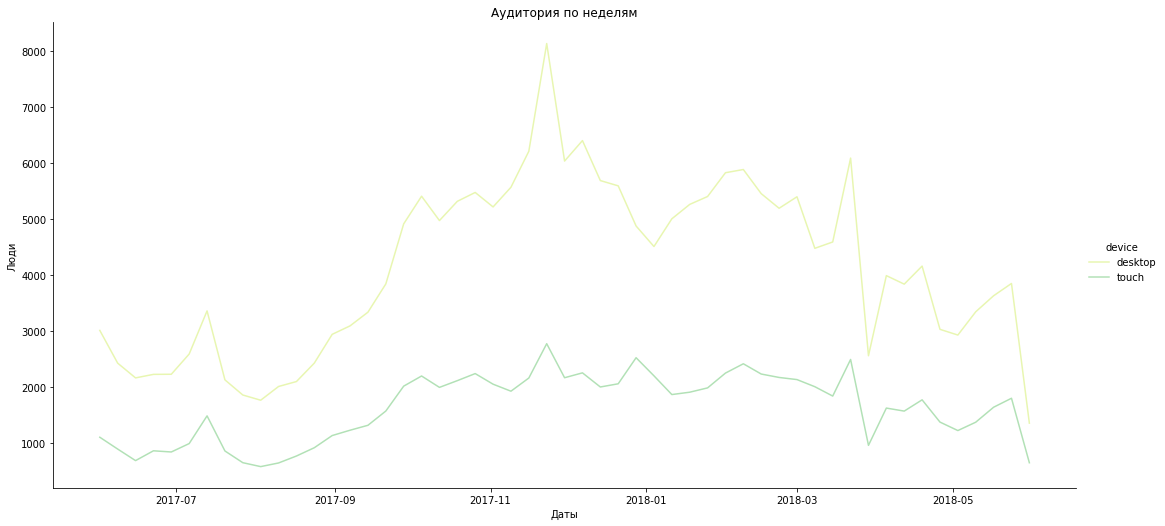

In [20]:
wau_device = visits.groupby(['device', 
                             'session_week']).agg({'uid': 'nunique'}).reset_index()

sns.relplot(x="session_week" , y="uid", hue="device", 
            kind="line", 
            height=7, 
            aspect=15/7, 
            data=wau_device)

plt.title("Аудитория по неделям")
plt.ylabel('Люди')
plt.xlabel('Даты');

Данные стали более шумными, график  повторяет форму численности ежемесячной аудитории, был мощный тренд на увеличение аудитории, но после конца 2017 года пошел на снижение. 

### Динамика DAU по платформам 

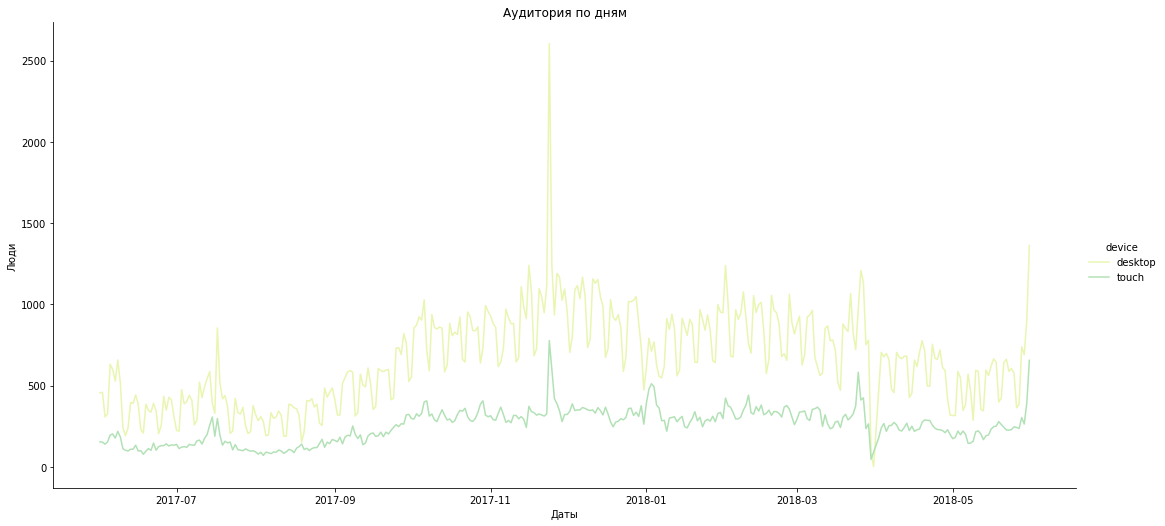

In [21]:
dau_device = visits.groupby(['device',  'session_day']).agg({'uid': 'nunique'}).reset_index()

sns.relplot(x="session_day" , y="uid", hue="device", 
            kind="line", 
            height=7, 
            aspect=15/7, 
            data=dau_device)
plt.title("Аудитория по дням")
plt.ylabel('Люди')
plt.xlabel('Даты');

Еще более шумные данные, зато появились интересные паттерны - резкий рост, затем резкое падение. Видимо, это связано с рекламной стратегией и графиком работы рекламных кампаний. В конце 17-го  виден очень сильный пик, можно было бы предположить, что это выброс, но на мобильной платформе число пользователей подскочило тоже двольно сильно. 

Сразу видно: Стинг приехал.  

## Посмотрим на эти же метрики, но в разрезе рекламных источников 

In [22]:
visits.groupby('source_id').agg({'uid':'nunique'}).sort_values(by = 'uid', ascending = False).T

source_id,4,3,5,2,1,9,10,7,6
uid,83525,74756,56974,26245,18999,9264,8067,34,6


Больше всего пользователей за период пришло с источников 4, 3, 5. Меньше всего уникальных пользователей пришло с источников 6 и 7 - чуть ли не случайным путем. Было бы здорово, если бы мы знали, что кроется за этими цифрами, но пока просто запомним, что 4,3,5 - источники с наибольшим охватом. 

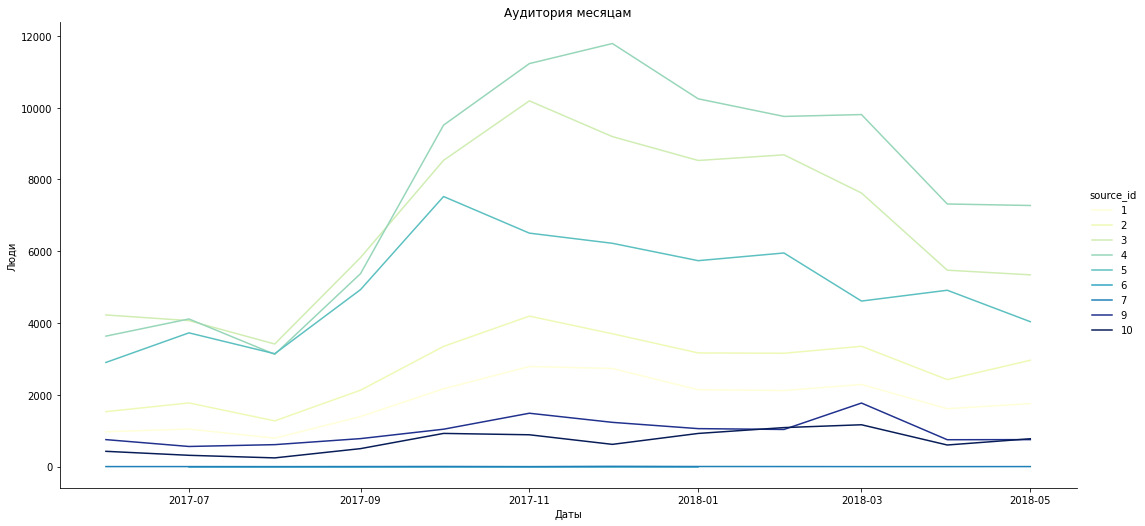

In [23]:
mau_ad = visits.groupby(['source_id', 
                             'session_month']).agg({'uid': 'nunique'}).reset_index()
sns.relplot(x="session_month" , y="uid", hue="source_id", 
            kind="line", 
            height=7, 
            aspect=15/7, legend = 'full', palette='YlGnBu',
            data=mau_ad)
plt.title("Аудитория месяцам")
plt.ylabel('Люди')
plt.xlabel('Даты');

Видно, что трафик с источников 3,4,5 - самый большой и почти одномоментно почти все источники начинают увеличивать трафик с августа 2017.
После видно довольно плавный спад и стабилизацию. Нагнали нужную аудиторию, дальше расчитывакм на увеличение прибыли с помощью ретеншена?  

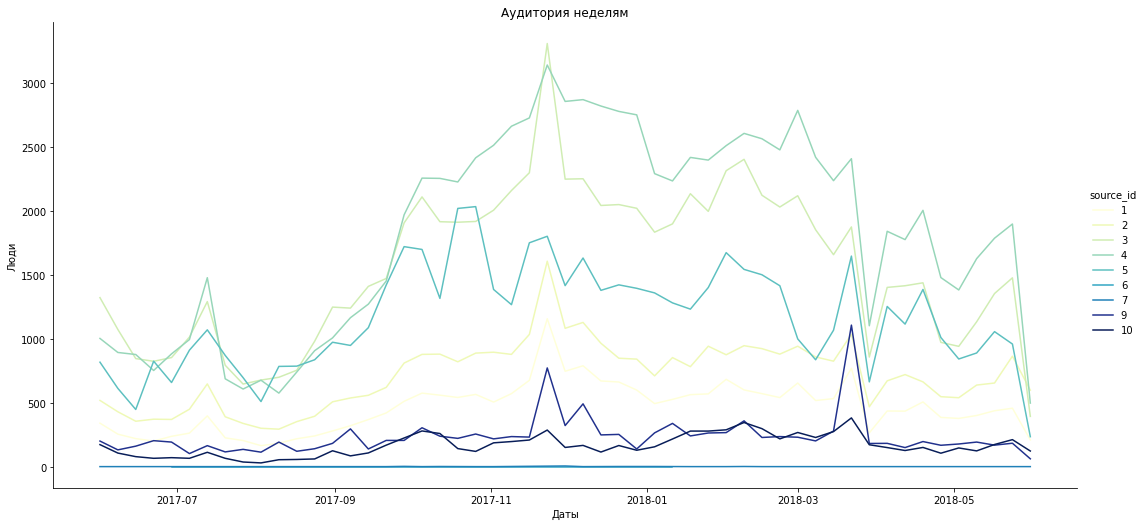

In [24]:
wau_ad = visits.groupby(['source_id', 
                             'session_week']).agg({'uid': 'nunique'}).reset_index()

sns.relplot(x="session_week" , y="uid", hue="source_id", 
            kind="line", 
            height=7, 
            aspect=15/7, legend = 'full', palette='YlGnBu',
            data=wau_ad)
plt.title("Аудитория неделям")
plt.ylabel('Люди')
plt.xlabel('Даты');

В целом картина не особо поменялась, но интересно, что в самом конце периода - сильный спад для источников-лидеров, они сравнялись состальными.

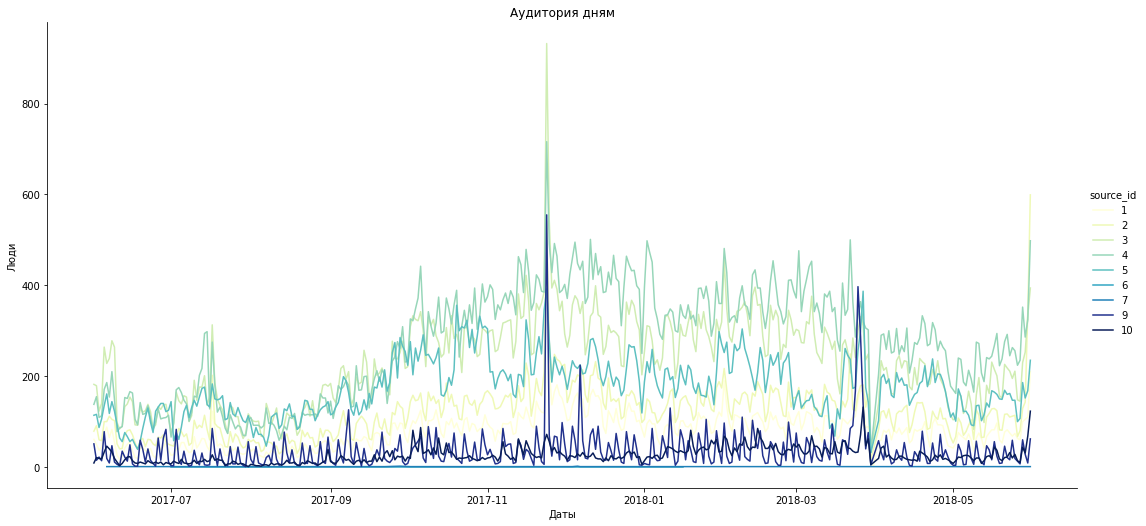

In [25]:
dau_ad = visits.groupby(['source_id', 
                             'session_day']).agg({'uid': 'nunique'}).reset_index()

sns.relplot(x="session_day" , y="uid", hue="source_id", 
            kind="line", 
            height=7, 
            aspect=15/7, legend = 'full', palette='YlGnBu',
            data=dau_ad)
plt.title("Аудитория дням")
plt.ylabel('Люди')
plt.xlabel('Даты');

Ужас какой. 

## *Сколько сессий в день ?*


In [26]:
user_sessions = visits.groupby(['session_day', 
                                'device', 
                                'source_id']).agg({'uid':'count'}) #разобьем данные по дням6 устройствам и рекламным источникам

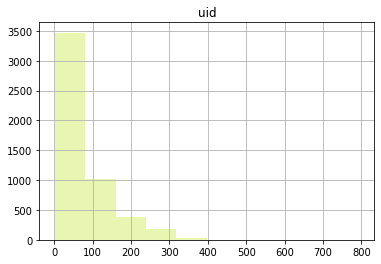

In [27]:
user_sessions.hist();

In [28]:
user_sessions.groupby('session_day')['uid'].sum().mode()

0    884
1    943
dtype: int64

Так как распределение сильно скошено вправо, лучше взять моду для представления типичного числа сессий. Значение колеблется от 884 до 943. 

При этом разделение по источникам в среднем в день выглядит так: 

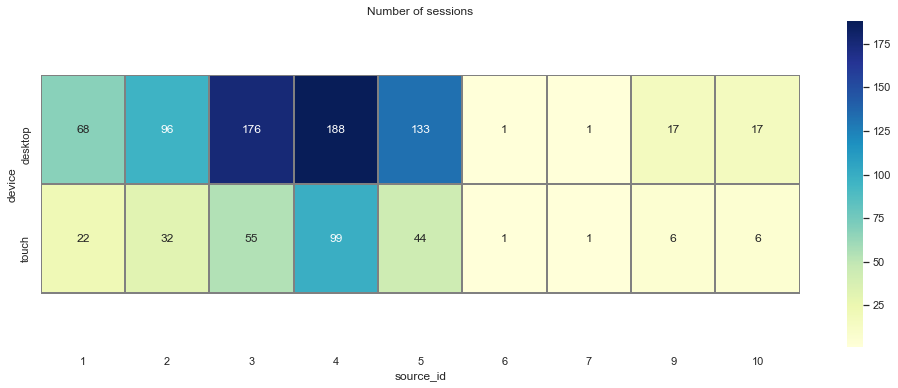

In [29]:
users_by_ad_and_device = user_sessions.pivot_table(index = ['device'],
                           columns = 'source_id',
                           values = 'uid', 
                           aggfunc = 'median')

sns.set(style='white')
plt.figure(figsize=(17, 6))
plt.title('Number of sessions')
ax = sns.heatmap(users_by_ad_and_device, fmt='', annot=True, linewidths=1, linecolor='gray', cmap='YlGnBu')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5);

Невероятно, но факт, источники 3,4,5 все еще в лидерах, причем пропорционально лидируют по количеству сессий на обеих платформах, тут тоже хорошо видно, что мобильный трафик сильно отстает. Разве это дело? В этой зоне точно есть куда расти. 

## *Сколько длится одна сессия?*



Нужно найти метрику ASL и выяснить, сколько в среднем времени пользователи проводят на сайте. 

In [30]:
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds #длительность каждой сессии в секундах 
visits['session_duration'].mode()

0    60
dtype: int64

Вот опять же, большая часть пользователей успевает проверить мероприятия меньше, чем за минуту: 0    60
dtype: int64


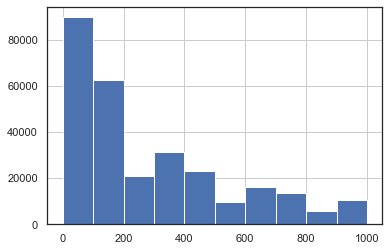

In [31]:
visits['session_duration'].hist(range = (0,1000));
print('Вот опять же, большая часть пользователей успевает проверить мероприятия меньше, чем за минуту: {}'.format(visits['session_duration'].mode()))

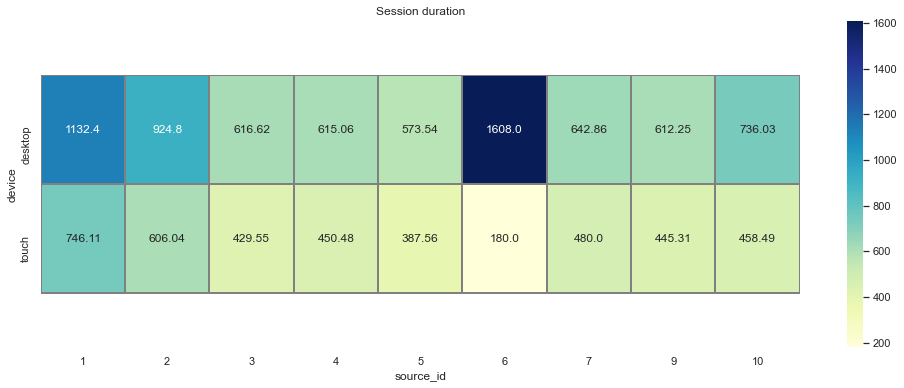

In [32]:
visits_duration  = visits.pivot_table(index = ['device'],
                           columns = 'source_id',
                           values = 'session_duration', 
                           aggfunc = 'mean')
sns.set(style='white')
plt.figure(figsize=(17, 6))
plt.title('Session duration')
ax = sns.heatmap(visits_duration, fmt='.5', annot=True, linewidths=1, linecolor='gray', cmap='YlGnBu')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5);

Видно, что пользователи с ПК явно больше проводят времени, на сайте, скорее всего версия удобнее для просмотра. Лидирующие по трафику источники 3,4,5 ведут себя довольно похоже. Интересно, что больше всего на сайте сидят пользователи из источников 1 и 2. На 6 - можно не смотреть, там данных так мало, что и анализировать их нельзя. 

## *Как часто люди возвращаются?*


### Сначала составим профили пользователей по информации из таблицы визитов - еще пригодится 

In [33]:
users = (visits.sort_values(by = ['uid', 'start_ts'])
        .groupby('uid')
        .agg({'start_ts':'first', 
              'source_id':'first',
             'device':'first'})
        .rename(columns = {'start_ts' : 'acquisition_ts'}))
#портрет пользователя с первым визитом, источником и типом девайса

In [34]:
users['acquisition_date'] = users['acquisition_ts'].dt.date #день первого визита
users['acquisition_month'] = users['acquisition_ts'].astype('datetime64[M]')#месяц первого визита

In [35]:
users = (users.reset_index()
 .set_index(['source_id', 'acquisition_date'])
 .join(costs.set_index(['source_id', 
                        'acquisition_date']), 
       how = 'left'))#добавим затраты по источникам привлечения и дням

In [36]:
user_cost = (users.groupby(['source_id', 'acquisition_date'])
 .agg({'device':'count', 'costs':'max'})
 .rename(columns={'device':'users'}))
#сгруппируем по источникам, дням, выведем количество пользователей и затраты в день 
user_cost['acquisition_cost'] = user_cost['costs']/user_cost['users'] #стоимость одного посетителя

In [37]:
users = users.join(user_cost[['acquisition_cost']], 
           how = 'left').reset_index()

In [38]:
users = users.set_index('uid')[['acquisition_ts', 
                        'acquisition_date',
                       'acquisition_month',
                       'source_id', 
                       'device', 
                       'acquisition_cost']]

In [39]:
#стал  ли посетитель покупателем
users = (users.join(orders.groupby('uid')
           .agg({'buy_ts':'min'})
            .rename(columns = {'buy_ts':'first_purchase_dt'}),
            how='left'))


In [40]:
users['payer'] = ~users['first_purchase_dt'].isna()

In [41]:
users.head() #портрет пользователя 

,acquisition_ts,acquisition_date,acquisition_month,source_id,device,acquisition_cost,first_purchase_dt,payer
uid,,,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.6,2017-09-11 00:06:00,True
618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.6,NaT,False
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.6,2017-06-01 09:23:00,True
1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.6,2017-06-01 16:47:00,True
1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop,1.6,NaT,False


In [42]:
first_visit = visits.groupby(['uid'])['session_month'].min() #первый визит
first_visit.name = 'first_visit'
visits = visits.join(first_visit, on='uid')
visits['cohort_lifetime'] = ((visits['session_month'] - visits['first_visit'])/np.timedelta64(1,'M')).round().astype(int)

Теперь у нас вполне себе исчерпывающая информация о каждом пользователе, можно считать метрики. 

## Retention

Тут придется потрудиться. В следующей ячейке можно выбрать условия построения когорот: по типам девайса, по первому месяцу или по источнику. Раскомментируй нужное условие и получишь расчет RR. 
Это сэкономит твое время, а я уменьшил объем написания кода на этом участке в три раза. 

In [43]:
dimensions = ['first_visit']
#dimensions = ['device']
#dimensions = ['source_id']

In [44]:
cohorts = visits.groupby(dimensions + ['cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 
#формирует когорты по выбранному условию

In [45]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0] #сколько было людей на старте когорты
initial_users_count.drop(columns = 'cohort_lifetime', inplace = True)
initial_users_count.rename(columns={'uid':'cohort_users'}, inplace = True)

/Library/Python/3.7/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Library/Python/3.7/site-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [46]:
cohorts = cohorts.merge(initial_users_count,on=dimensions)

In [47]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] #посчитаем сам ретеншн в каждой когорте

In [48]:
retention_pivot = cohorts.pivot_table(index = dimensions, columns = 'cohort_lifetime', values = 'retention', aggfunc = 'sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


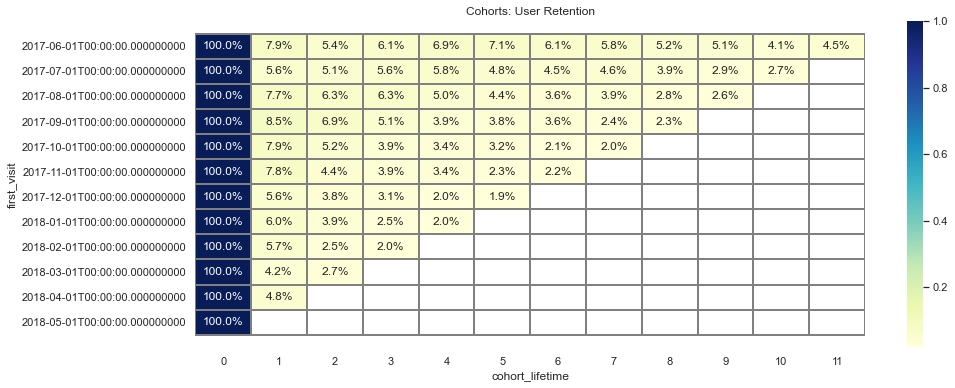

In [49]:
sns.set(style='white')
plt.figure(figsize=(15, 6))
plt.title('Cohorts: User Retention')
ax = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap='YlGnBu')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5);

Ну, начем с **источников привлечения**. 

Во-первых, ретеншн - небольшой, что логично. Люди не так часто ходят на мероприятия, зашли на сайт, купили билет, ушли. 
Но, интересно, что по источникам 9, 1, 2 - он значительно превышает остальной. Возможно эта аудитория пользуется и онлайн сервисами на сайте, поэтому возвращается чаще. В целом, согласуется с тем выводом, что пользователи с 1 и 2 канала больше времени проводят на сайте. 


С **девайсами** тоже идет логичное продолжение, людям приятнее пользоваться полной версией сайта. Разницу в трафике можно легко объяснить рекламными источниками, но ретеншн, говорит о пользовательском опыте, складывается впечателение, что можно поработать над мобильной версией, там есть, что улучшить. 

А вот с **временными когортами** уже интересно, сам по себе ретеншн падает сильно, с одной стороны логично - повторный трафик тоже зависит от рекламы, которую сокращали во второй периоде, с другой, это может быть колокольчик, что не людям стало меньше нравиться пользоваться сервисом. 


# **Анализ продаж**

## *Когда люди начинают покупать?*

In [50]:
orders['order_day'] = orders['buy_ts'].astype('datetime64[D]') #день заказа
orders['order_day'] = pd.to_datetime(orders['order_day'])
buyers = users[users['payer'] == True].copy() #выберем из всех пользователей покупателей 
buyers['time_from_first_visit'] = (buyers['first_purchase_dt'] -buyers['acquisition_date']).dt.days #расстояние от первого визита и до покупки

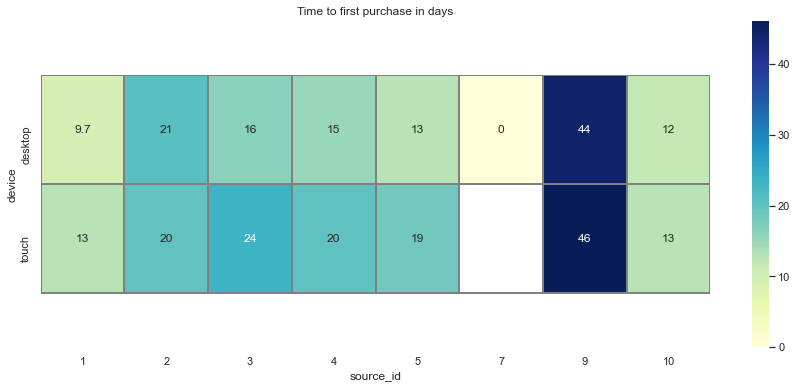

In [51]:
sns.set(style='white')
plt.figure(figsize=(15, 6))
plt.title('Time to first purchase in days')
ax = sns.heatmap(buyers.pivot_table(index = 'device',  columns = 'source_id', 
                                                       values = 'time_from_first_visit', 
                                                       aggfunc = 'mean'), 
                 annot=True,
                 linewidths=1,
                 linecolor='gray',
                cmap='YlGnBu')

i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5);

А вот здесь можно сделать интересные выводы: тройка лидеров по трафику ведет себя все еще здорово, но не сильно отличаются от среднего результата, а вот у источника №1 очень высокая лояльность - покупают значительно быстрее и в мобильной версии и в полной. Мобильная снова отстает от полной, на одно и то же действие люди решаются с разной скоростью - еще один довод посмотреть внимательнее на опыт мобильных пользователей. 

## *Сколько раз люди покупают за период?*

In [52]:
users_first_visit = users[['source_id', 'device']]

In [53]:
buyers = orders.groupby(['order_year', 'purchase_month', 'order_day', 'uid']).agg({'buy_ts':'count','revenue':'sum'})

In [54]:
buyers = buyers.join(users_first_visit, on = 'uid')

In [55]:
buyers #таблица с заказами покупателей и их характеристиками

buy_ts  revenue  \
order_year purchase_month order_day  uid                                     
2017       2017-06-01     2017-06-01 585738041899923335         1     0.15   
                                     1074355127080856382        1     0.37   
                                     1186685127129229501        1    10.00   
                                     1292867924428534308        1     4.28   
                                     1306739390297736782        1     1.34   
...                                                           ...      ...   
2018       2018-05-01     2018-05-31 18268785503361436132       1     4.64   
                                     18315976142101556204       1    15.89   
                                     18334852012373166529       1     6.60   
                                     18413715920446116327       1     3.67   
           2018-06-01     2018-06-01 83872787173869366          1     3.42   

                                                           source_id   device  
order_year purchase_month order_day  uid                                       
2017       2017-06-01     2017-06-01 585738041899923335            4  desktop  
                                     1074355127080856382           1  desktop  
                                     1186685127129229501           3  desktop  
                                     1292867924428534308           1  desktop  
                                     1306739390297736782           3  desktop  
...                                                              ...      ...  
2018       2018-05-01     2018-05-31 18268785503361436132          4  desktop  
                                     18315976142101556204          2    touch  
                                     18334852012373166529          3  desktop  
                                     18413715920446116327          4  desktop  
           2018-06-01     2018-06-01 83872787173869366             4  desktop  

[46548 rows x 4 columns]

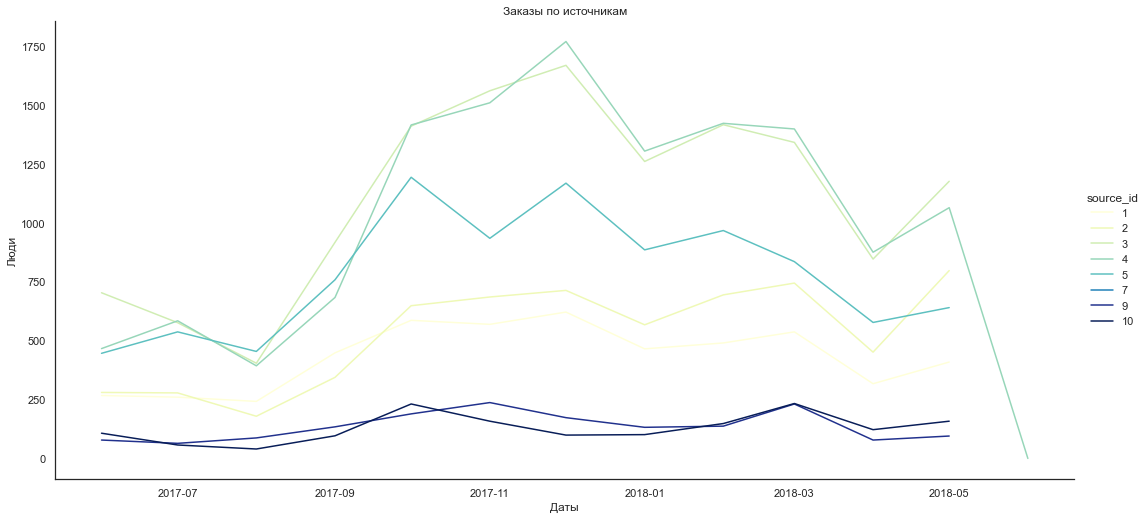

In [56]:
sales = buyers.groupby(['purchase_month','source_id' ])['buy_ts'].sum().reset_index()

sns.relplot(x="purchase_month" , y="buy_ts", hue="source_id", 
            kind="line", 
            height=7, 
            aspect=15/7, legend = 'full', palette='YlGnBu', 
            data=sales)
plt.title("Заказы по источникам")
plt.ylabel('Люди')
plt.xlabel('Даты');

Количество заказов пропорционально трафику, думаю ничего удивительного в этом нет. Можно еще посмотреть на выручку по источникам

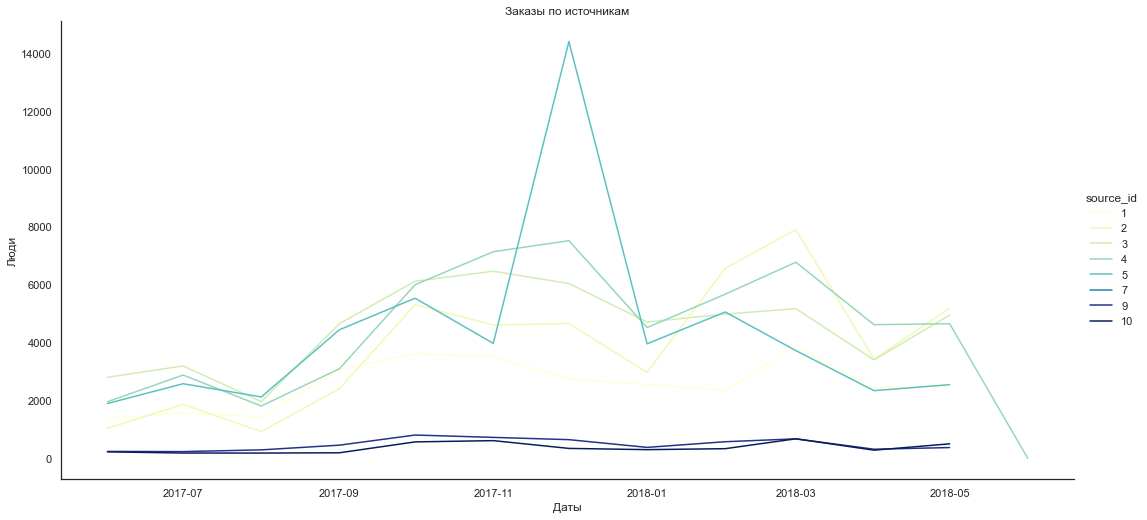

In [57]:
sales = buyers.groupby(['purchase_month','source_id' ])['revenue'].sum().reset_index()

sns.relplot(x="purchase_month" , y="revenue", hue="source_id", 
            kind="line", 
            height=7, 
            aspect=15/7, legend = 'full', palette='YlGnBu',
            data=sales)
plt.title("Заказы по источникам")
plt.ylabel('Люди')
plt.xlabel('Даты');

В целом история повторяется, но видно огромный пик по выручке из 5-го источника, он приходится на период пика и по количеству посетителей на сайт, аномально хорошо сработал этот источник, ничего не скажешь. 

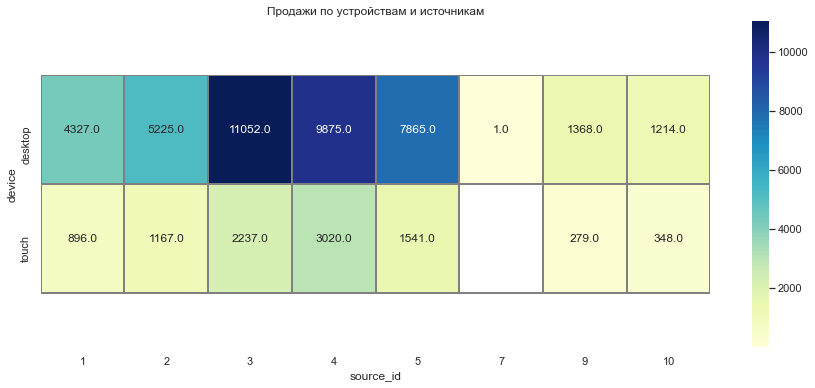

In [58]:
sns.set(style='white')
plt.figure(figsize=(15, 6))
plt.title('Продажи по устройствам и источникам')
ax = sns.heatmap(buyers.pivot_table(index = ['device'], 
                   columns = 'source_id', 
                   values = 'buy_ts', 
                   aggfunc = 'sum'), fmt= '', annot=True, linewidths=1, linecolor='gray',cmap = 'YlGnBu' )
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5);

По заказам тоже картина ожидаемо сложилась, в целом их больше всего у тройли лидеров. Гораздо интереснее разрыв между количеством заказов с сайта и с мобильной версии, там точно есть к чему стремиться. 

## *Какой средний чек?*


In [59]:
buyers.reset_index(inplace = True)
avg_bill =  buyers.groupby(['order_year', 'device', 'source_id']).agg({'revenue':'sum', 'uid':'nunique'})
avg_bill['bill'] = avg_bill['revenue']/ avg_bill['uid']

In [60]:
(avg_bill.reset_index()
 .pivot_table(index = ['order_year', 'device'], 
              columns = 'source_id',
              values = 'bill', 
              aggfunc = 'mean'))

source_id                  1          2         3         4         5     7   \
order_year device                                                              
2017       desktop  11.301630  10.973459  5.342339  5.375979  9.146910  1.22   
           touch     5.899389   9.448711  4.774183  5.703954  4.905279   NaN   
2018       desktop  10.231828  18.067396  4.773199  5.103343  6.220386   NaN   
           touch     9.505073   5.181542  4.289232  5.131822  4.099626   NaN   

source_id                 9         10  
order_year device                       
2017       desktop  5.347119  3.444460  
           touch    4.437913  3.117852  
2018       desktop  4.446993  3.205320  
           touch    3.985729  2.952611

Средний чек немного упал  сразу у всех лидеров, зато ощутимо подрос у источника 2, пользователи реже покупают с мобильных версий, поэтому и средний чек там ниже. 

## *Сколько денег приносят? (LTV)*

In [61]:
#условия формирования когорты 
#dimensions = ['acquisition_month']
#dimensions = ['device']
dimensions = ['source_id']


In [62]:
#строим когорты по условию, вычисляя количество покупателей в когорте и общие затраты
cohorts = (users.groupby(dimensions)
 .agg({'payer':'sum', 'acquisition_cost': 'sum'})
 .rename(columns = {'payer':'cohorts_size'}))

In [63]:
#цена привлечения одного покупателя в когорте
cohorts['cac'] = cohorts['acquisition_cost']/cohorts['cohorts_size']
cohorts

,cohorts_size,acquisition_cost,cac
source_id,,,
1,2899,20833.27,7.186364
2,3506,42806.04,12.209367
3,10473,141321.63,13.493901
4,10296,61073.60,5.931779
5,6931,51756.40,7.467378
6,0,0.00,NaN
7,1,0.00,0.000000
9,1088,5454.42,5.013254
10,1329,5821.12,4.380075


Теперь соберем необходимый данные из таблиц с портретами пользователей и заказами этих пользоватеелй, в таблице оставим дату привлечения пользователя, источник и девайс, месяц покупки и выручку

In [64]:
#считаем LTV
ltv = (orders.set_index('uid')
.join(users, how = 'left')[['acquisition_month',
                         'source_id',
                         'device',
                         'purchase_month',
                         'revenue']])

In [65]:
#возраст когорт
ltv['age_month'] = ((ltv['purchase_month'] - ltv['acquisition_month'])/np.timedelta64(1,'M')).round().astype('int')

In [66]:
ltv  = (ltv.groupby(dimensions + ['age_month'])
 .agg({'revenue' : 'sum'})) #группировка по когортам и возрасту

In [67]:
ltv = ltv.pivot_table(index = dimensions, 
                columns = 'age_month',
               values = 'revenue',
               aggfunc = 'sum')

In [68]:
ltv.fillna('')
#общий  доход на когорту на определенный месяц жизни когорты

age_month,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,14526.97,2613.99,1795.52,2734.87,1691.99,1114.23,934.4,2208.12,1252.73,869.44,823.63,524.66
2,17905.40,6059.01,6046.16,6497.13,3193.57,2474.25,1220.65,781.72,751.76,953.04,655.49,385.43
3,37710.74,5914.19,2474.9,2237.32,1988.45,1378.88,1072.33,579.89,513.36,295.13,196.17,149.88
4,37452.58,4456.89,2125.44,2080.92,1763.52,2149.3,2080.58,714.13,950.28,1366.02,794.77,762.4
5,28782.52,3422.46,2015.11,10872.9,1756.89,2154.24,1152.34,925.3,543.22,783.15,135.06,80.82
7,1.22,,,,,,,,,,,
9,2374.56,631.02,572.04,508.61,456.79,226.14,277.07,199.49,276.01,163.92,58.23,15.52
10,3554.47,302.85,127.29,76.72,172.14,80.42,71.58,25.97,4.28,17.69,7.82,9.1


In [69]:
ltv = ltv.cumsum(axis=1)
ltv.fillna('') #общий накопительный доход на когорту

age_month,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,14526.97,17141,18936.5,21671.3,23363.3,24477.6,25412,27620.1,28872.8,29742.3,30565.9,31090.5
2,17905.40,23964.4,30010.6,36507.7,39701.3,42175.5,43396.2,44177.9,44929.6,45882.7,46538.2,46923.6
3,37710.74,43624.9,46099.8,48337.2,50325.6,51704.5,52776.8,53356.7,53870.1,54165.2,54361.4,54511.2
4,37452.58,41909.5,44034.9,46115.8,47879.3,50028.6,52109.2,52823.4,53773.6,55139.7,55934.4,56696.8
5,28782.52,32205,34220.1,45093,46849.9,49004.1,50156.5,51081.8,51625,52408.1,52543.2,52624
7,1.22,,,,,,,,,,,
9,2374.56,3005.58,3577.62,4086.23,4543.02,4769.16,5046.23,5245.72,5521.73,5685.65,5743.88,5759.4
10,3554.47,3857.32,3984.61,4061.33,4233.47,4313.89,4385.47,4411.44,4415.72,4433.41,4441.23,4450.33


In [70]:
ltv = cohorts[['cohorts_size']].join(ltv)

In [71]:
ltv = ltv.div(ltv['cohorts_size'], axis= 0).drop(columns = ['cohorts_size'])
ltv.fillna('')

,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,5.01103,5.91271,6.53207,7.47546,8.0591,8.44345,8.76577,9.52745,9.95958,10.2595,10.5436,10.7246
2,5.10707,6.83526,8.55977,10.4129,11.3238,12.0295,12.3777,12.6007,12.8151,13.0869,13.2739,13.3838
3,3.60076,4.16547,4.40178,4.61541,4.80527,4.93693,5.03932,5.09469,5.14371,5.17189,5.19062,5.20493
4,3.63759,4.07046,4.27689,4.479,4.65029,4.85904,5.06111,5.13047,5.22277,5.35544,5.43264,5.50669
5,4.15272,4.64651,4.93725,6.50599,6.75947,7.07028,7.23654,7.37004,7.44842,7.56141,7.5809,7.59256
6,,,,,,,,,,,,
7,1.22,,,,,,,,,,,
9,2.1825,2.76248,3.28825,3.75573,4.17557,4.38342,4.63808,4.82143,5.07512,5.22578,5.2793,5.29357
10,2.67454,2.90242,2.9982,3.05593,3.18546,3.24597,3.29983,3.31937,3.32259,3.3359,3.34178,3.34863


В целом LTV  у нас весьма неплох, доход с клиента в течение года кратно прирастает, но эту метрику надо смотреть в паре с издержками на привлечение и сразу проверять окупаемость пользователей. 

Главное не большой LTV, а чтобы он больше CACа был. 

In [72]:
roi = cohorts[['cac']].join(ltv)

In [73]:
roi = roi.div(roi['cac'], axis= 0).drop(columns = ['cac'])
roi.fillna('')

,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,0.697297,0.822769,0.908954,1.04023,1.12144,1.17493,1.21978,1.32577,1.3859,1.42763,1.46717,1.49235
2,0.418291,0.559837,0.701083,0.852863,0.927469,0.98527,1.01379,1.03205,1.04961,1.07187,1.08719,1.09619
3,0.266843,0.308693,0.326205,0.342036,0.356107,0.365864,0.373452,0.377555,0.381188,0.383276,0.384664,0.385725
4,0.613237,0.686213,0.721014,0.755086,0.783961,0.819153,0.85322,0.864913,0.880473,0.90284,0.915853,0.928336
5,0.556115,0.622242,0.661176,0.871255,0.9052,0.946823,0.969087,0.986965,0.997461,1.01259,1.0152,1.01676
6,,,,,,,,,,,,
7,inf,,,,,,,,,,,
9,0.435346,0.551036,0.655912,0.749159,0.832906,0.874366,0.925163,0.961737,1.01234,1.04239,1.05307,1.05591
10,0.610616,0.662642,0.684509,0.697689,0.72726,0.741076,0.753372,0.757834,0.758569,0.761608,0.762951,0.764514


Так стало сильно понятнее, **по месяцу привлечения** окупились пока только когорты из сентября 2017 и июня 2017 на 3-ий и четвертый месяц соответсвенно, остальные же пока в процессе, но видимо, из-за низкого ретеншена, дело идет долго. 

А вот с пользователями по платформам все стало хуже, пока еще никакая платформа не окупила свои вложения, но приблизилась только полная версия сайта. Мобильные пользователи ощутимо хуже отбиваются, значит дело не только в бюджетах, но и в качестве услуг для этого сегмента. 

И да, как всегда дьявол в деталях. В когортах, разбитых по источникам трафика, видно, что 3-ий то источник, совсем не окупился и значительно тянет статистику вниз. При том, что большиснтво источников уже окупилось за год, из-за 3-го источника, в среднем пока не окупились.  В то же время самая лояльная аудитория из первой группы - не просто окупилась, но и принесла ощутимую прибыль не вложения, сработав по факту - эффетивнее других источников. 

In [74]:
roi.mean(axis=0) #окупаемость в среднем 

0          inf
1     0.601919
2     0.665550
3     0.758331
4     0.807764
5     0.843926
6     0.872551
7     0.900974
8     0.923649
9     0.943174
10    0.955156
11    0.962828
dtype: float64

Пока в среднем инвестиции окупаются у нас в конце периода, что довольно долго. С другой стороны, у подобных сервисов очень высокий срок LTV, если пользователю все же удобно работать с нами, скорее всего он продолжит покупать на сайте. 

# Маркетинг

## Сколько денег потратили? Всего / на каждый источник / по времени

## CAC


In [75]:
costs['month'] = costs['acquisition_date'].astype('datetime64[M]')

In [76]:
costs['costs'].sum() #потратили всего на маркетинг 

329131.62

In [77]:
orders['revenue'].sum() #для масштабов сравним с выручкой

252057.19999999998

В целом да, пока довольно грустно, но все еще впереди. 

In [78]:
costs.pivot_table(index='source_id', columns = 'month', values = 'costs', aggfunc = 'sum')

month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,1125.61,1072.88,951.81,1502.01,2315.75,2445.16,2341.20,2186.18,2204.48,1893.09,1327.49,1467.61
2,2427.38,2333.11,1811.05,2985.66,4845.00,5247.68,4897.80,4157.74,4474.34,3943.14,2993.70,2689.44
3,7731.65,7674.37,6143.54,9963.55,15737.24,17025.34,16219.52,14808.78,14228.56,13080.85,9296.81,9411.42
4,3514.80,3529.73,3217.36,5192.26,6420.84,5388.82,7680.47,5832.79,5711.96,5961.87,4408.49,4214.21
5,2616.12,2998.14,2185.28,3849.14,5767.40,6325.34,5872.52,5371.52,5071.31,4529.62,3501.15,3669.56
9,285.22,302.54,248.93,415.62,609.41,683.18,657.98,547.16,551.50,480.29,373.49,362.17
10,314.22,329.82,232.57,460.67,627.24,792.36,645.86,614.35,480.88,526.41,388.25,409.86


In [79]:
costs.pivot_table(index='source_id', columns = 'month', values = 'costs', aggfunc = 'sum').sum(axis=1)

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
dtype: float64

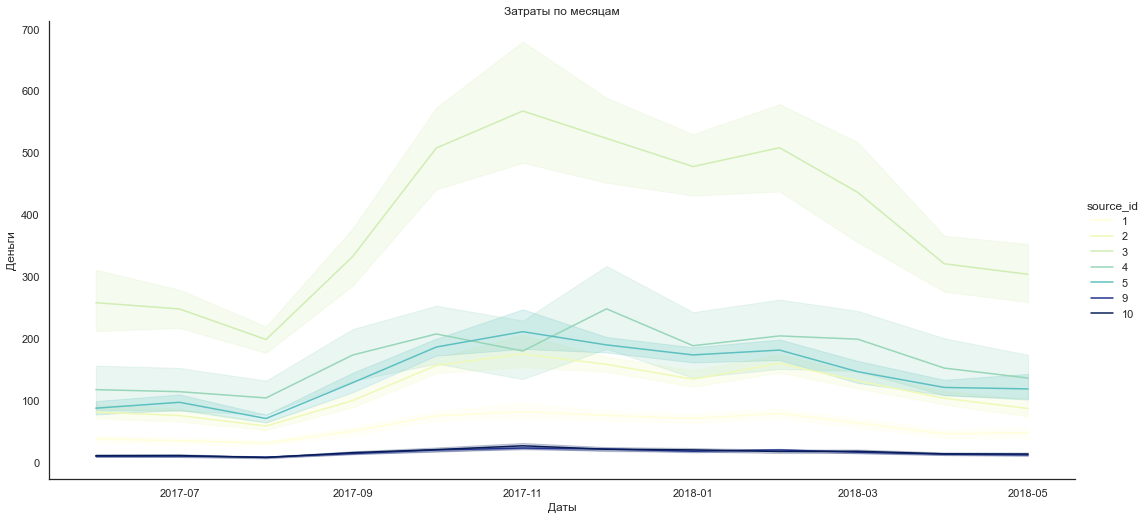

In [80]:
sns.relplot(x="month" , y="costs", hue="source_id", 
            kind="line", 
            height=7, 
            aspect=15/7, 
            data=costs, legend = 'full', palette='YlGnBu')
plt.title("Затраты по месяцам")
plt.ylabel('Деньги')
plt.xlabel('Даты');

Конечно третий источник не окупился, в него по сути ушла почти половина всего рекламного бюджета, это ему очень долго надо окупаться, а учитывая, что у нас еще довольно низкий retenrion непонятно, окупятся ли вообще такие инвестии. Этот рекламный источник целесообразнее всего удалить вообще.

## Сколько стоило привлечение одного покупателя из каждого источника?

In [81]:
user_cost.groupby('source_id')['acquisition_cost'].median().reset_index()

,source_id,acquisition_cost
0,1,2.182000
1,2,2.487742
2,3,2.087749
3,4,0.822801
4,5,1.015092
5,6,NaN
6,7,NaN
7,9,1.385714
8,10,0.857333


Самые дорогие источники 1 и 2, но и публики там немного, зато она очень лояльная. А вот такая цена для 3-го источника - слишком неэффектиная, при схожих объемах истчников 4 и 5, они сработали в два раза дешевле. 

# Вывод:

## О пользователях и устройствах: 

Большая часть трафика идет с пользователями ПК, что логично - у Я.Афиши большой сайт, много информации, такие сайты удобно смотреть с компьютора. Но сейчас 2020, большую часть времени пользователи проводят со смартфоном в руках, особенно активно они решают с ним повседневные задачи: ведут бюджет, составляют списки покупок, отправляют почту, читают статьи. Например у ютуба аудитория со смартфонов превысила аудиторию пользователей ПК. 

Но не только количество отличается. Пользователи смарфтфонов реже и медленее покупают, у них ниже ретенш. Если количество покупок объясняется зависимостью от трафика, то ретеншен и увеличенный срок покупки говорят о худшем пользовательском опыте, в сравнении с ПК. Пользователю сложнее совершить покупку, а сайт не настолько удобный, чтобы пользоваться им регулярно. 


Думаю, Афише стоит задуматься о более удобной версии сайта, провести UX-исследование может быть, я уверен, что не стоит недооценивать мобильную адиторию, а качеству опыта пользователей всегда есть куда расти. 


## Об источниках трафика: 

Больше всего пользователей за период пришло с источников 4, 3, 5.
При этом источники 4 и 5 - эффективны, с ними можно продолжать работать. 
А источник 3 - не окупается. Объемы у него большие, но, учитывая низкий ретенгшн, пользователи с этого источника могут никогда не окупиться. Рекомендую убрать его вообще, тогда и половина бюджета освободиться. 


Меньше всего уникальных пользователей пришло с источников 6 и 7 - чуть ли не случайным путем. Можно освободившиеся деньги после удаления 3-го источника отправить в них, так как трафик слишком маленький для анализа и мы не знаем, что именно за ними стоит. 


1 и 2 - дорогие источники, но зато публика там очень лояльная и быстро окупается. Можно понемногу увеличивать бюджет этих источников, не нарушая целостность остальных метрик, тогда они принесут гораздо больше денег. 

## Общие: 

Это, конечно, логично, что ретенш низкий, но это довольно важный показатель, который точно можно улучшить рассылками, более удобным интерфейсом и анализом поведения пользователей. Особенно надо сосредоточиться на мобильной версии.

Так же почти во всех группах упал средний чек, если мы приведем больше лояльных пользователей, у которых выше средний чек, что и средняя температура по больнице изменится в лучшую сторону. 